In [1]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler as minmax
from sklearn.preprocessing import LabelEncoder

import os

# IMPORTANT: PATH MIGHT BE DIFFERENT. SEE STEP 6
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
os.environ["RUNFILES_DIR"] = "/usr/local/share/plaidml"
os.environ["PLAIDML_NATIVE_PATH"] = "/usr/local/lib/libplaidml.dylib"

# Don't use tensorflow.keras anywhere, instead use keras
import keras
from keras.layers import Dense
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K



Using plaidml.keras.backend backend.


In [2]:
url="https://iaq-data.brgr.rocks/full.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')),parse_dates=['timestamp'],index_col='timestamp')

# data = pd.read_csv("nyc.csv",parse_dates=['Date'],index_col='Date')

In [3]:
train_cols = ["co2","livingroom_window_open"]
data = data[train_cols]

In [4]:
data.isna().sum()

co2                       0
livingroom_window_open    0
dtype: int64

In [5]:
data.dropna(inplace=True)

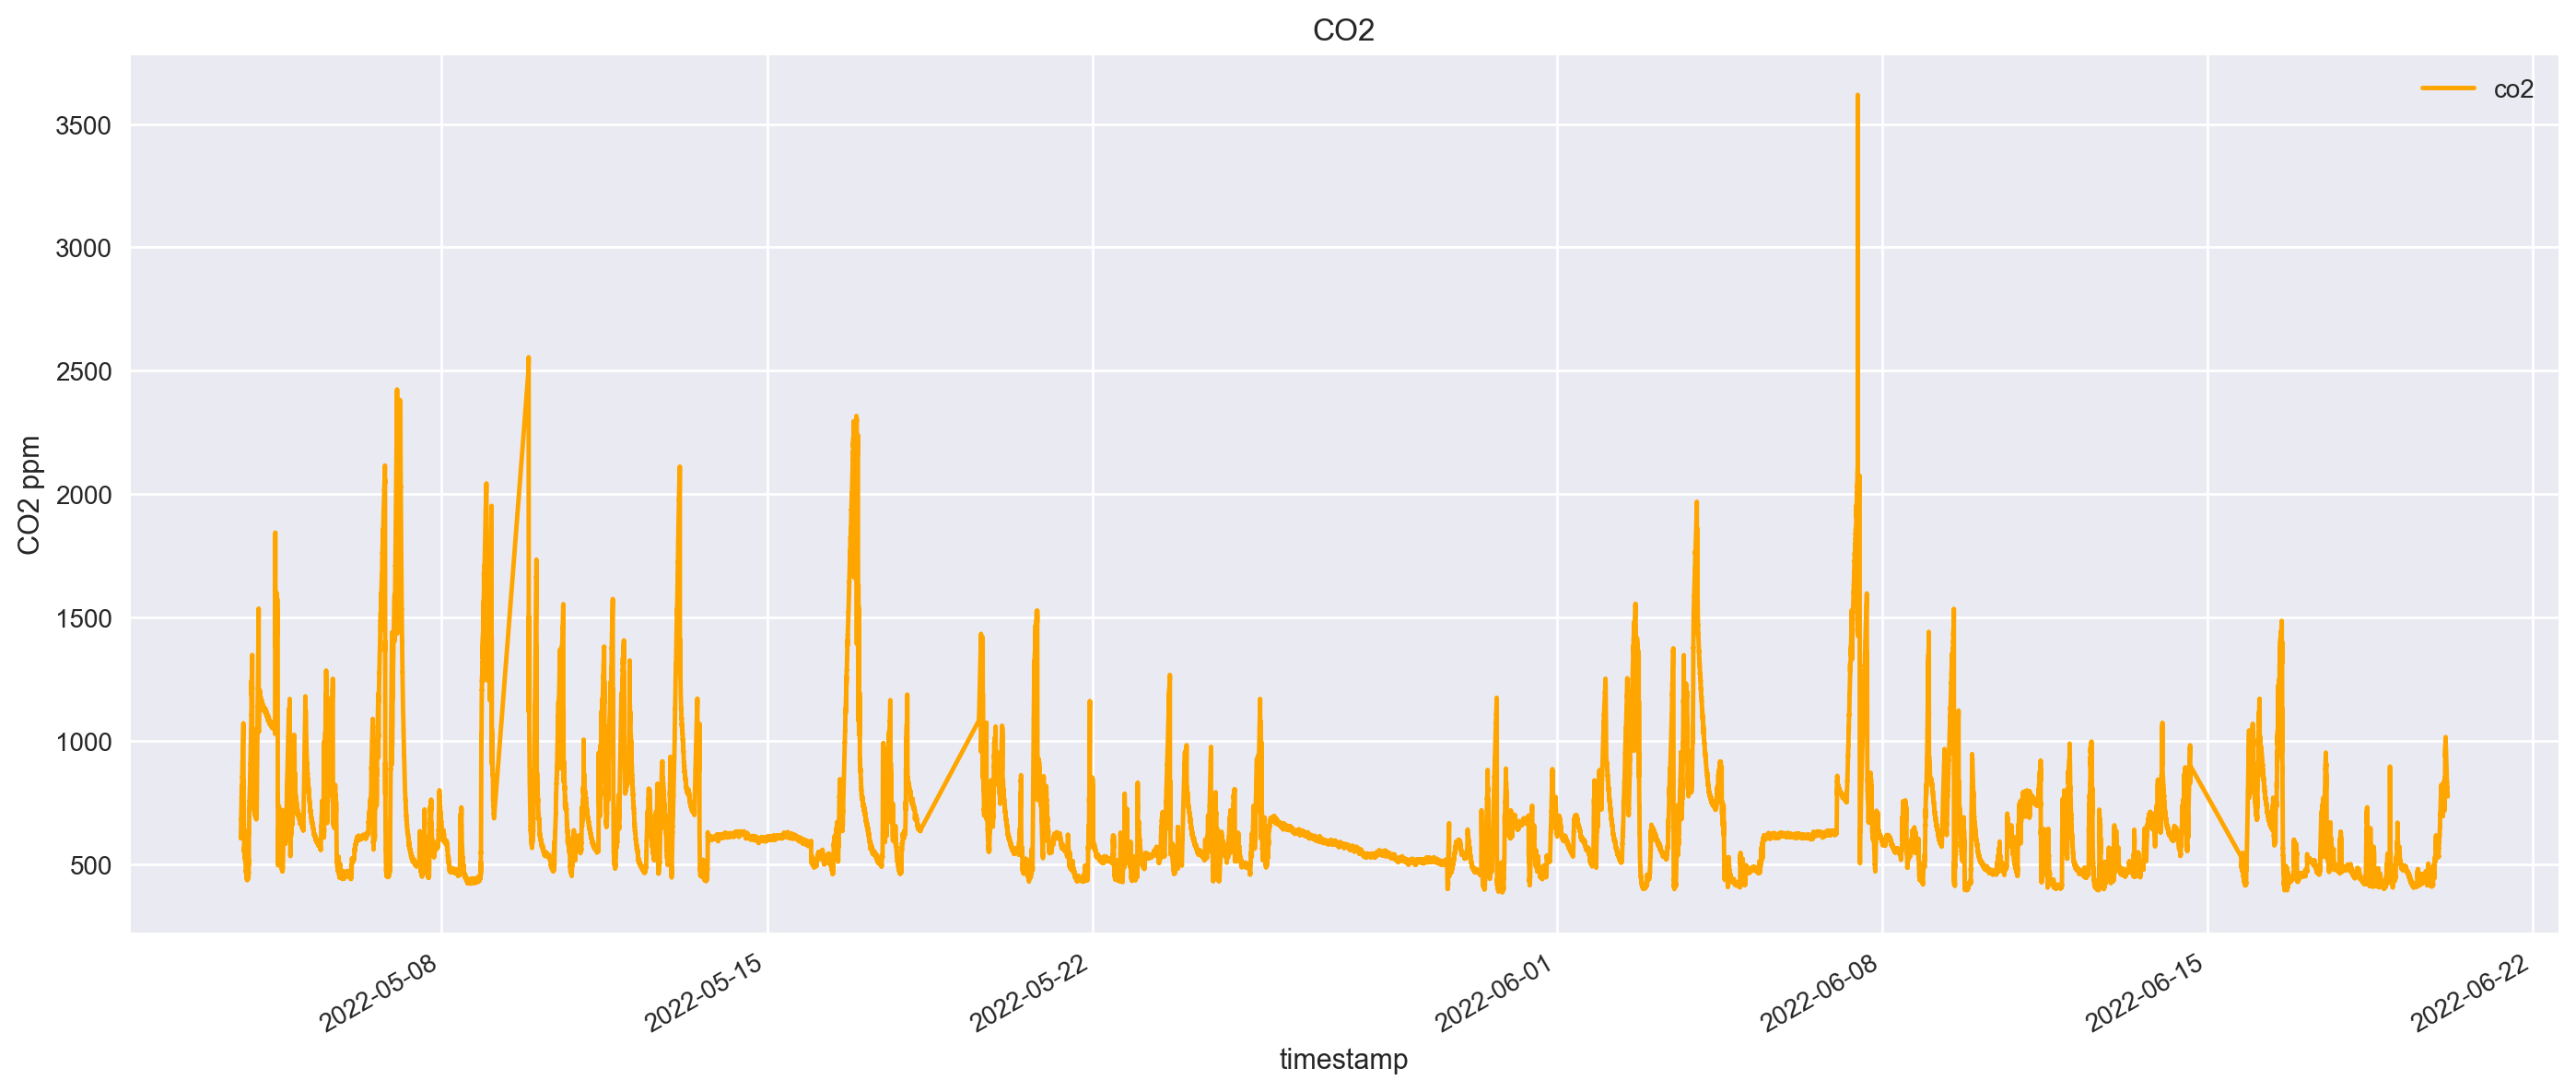

In [7]:
#Visualize our data

plt.figure(dpi=200,figsize=(17,7))
data["co2"].plot(legend=True,color='orange')
plt.title('CO2')
plt.ylabel("CO2 ppm")
plt.show()

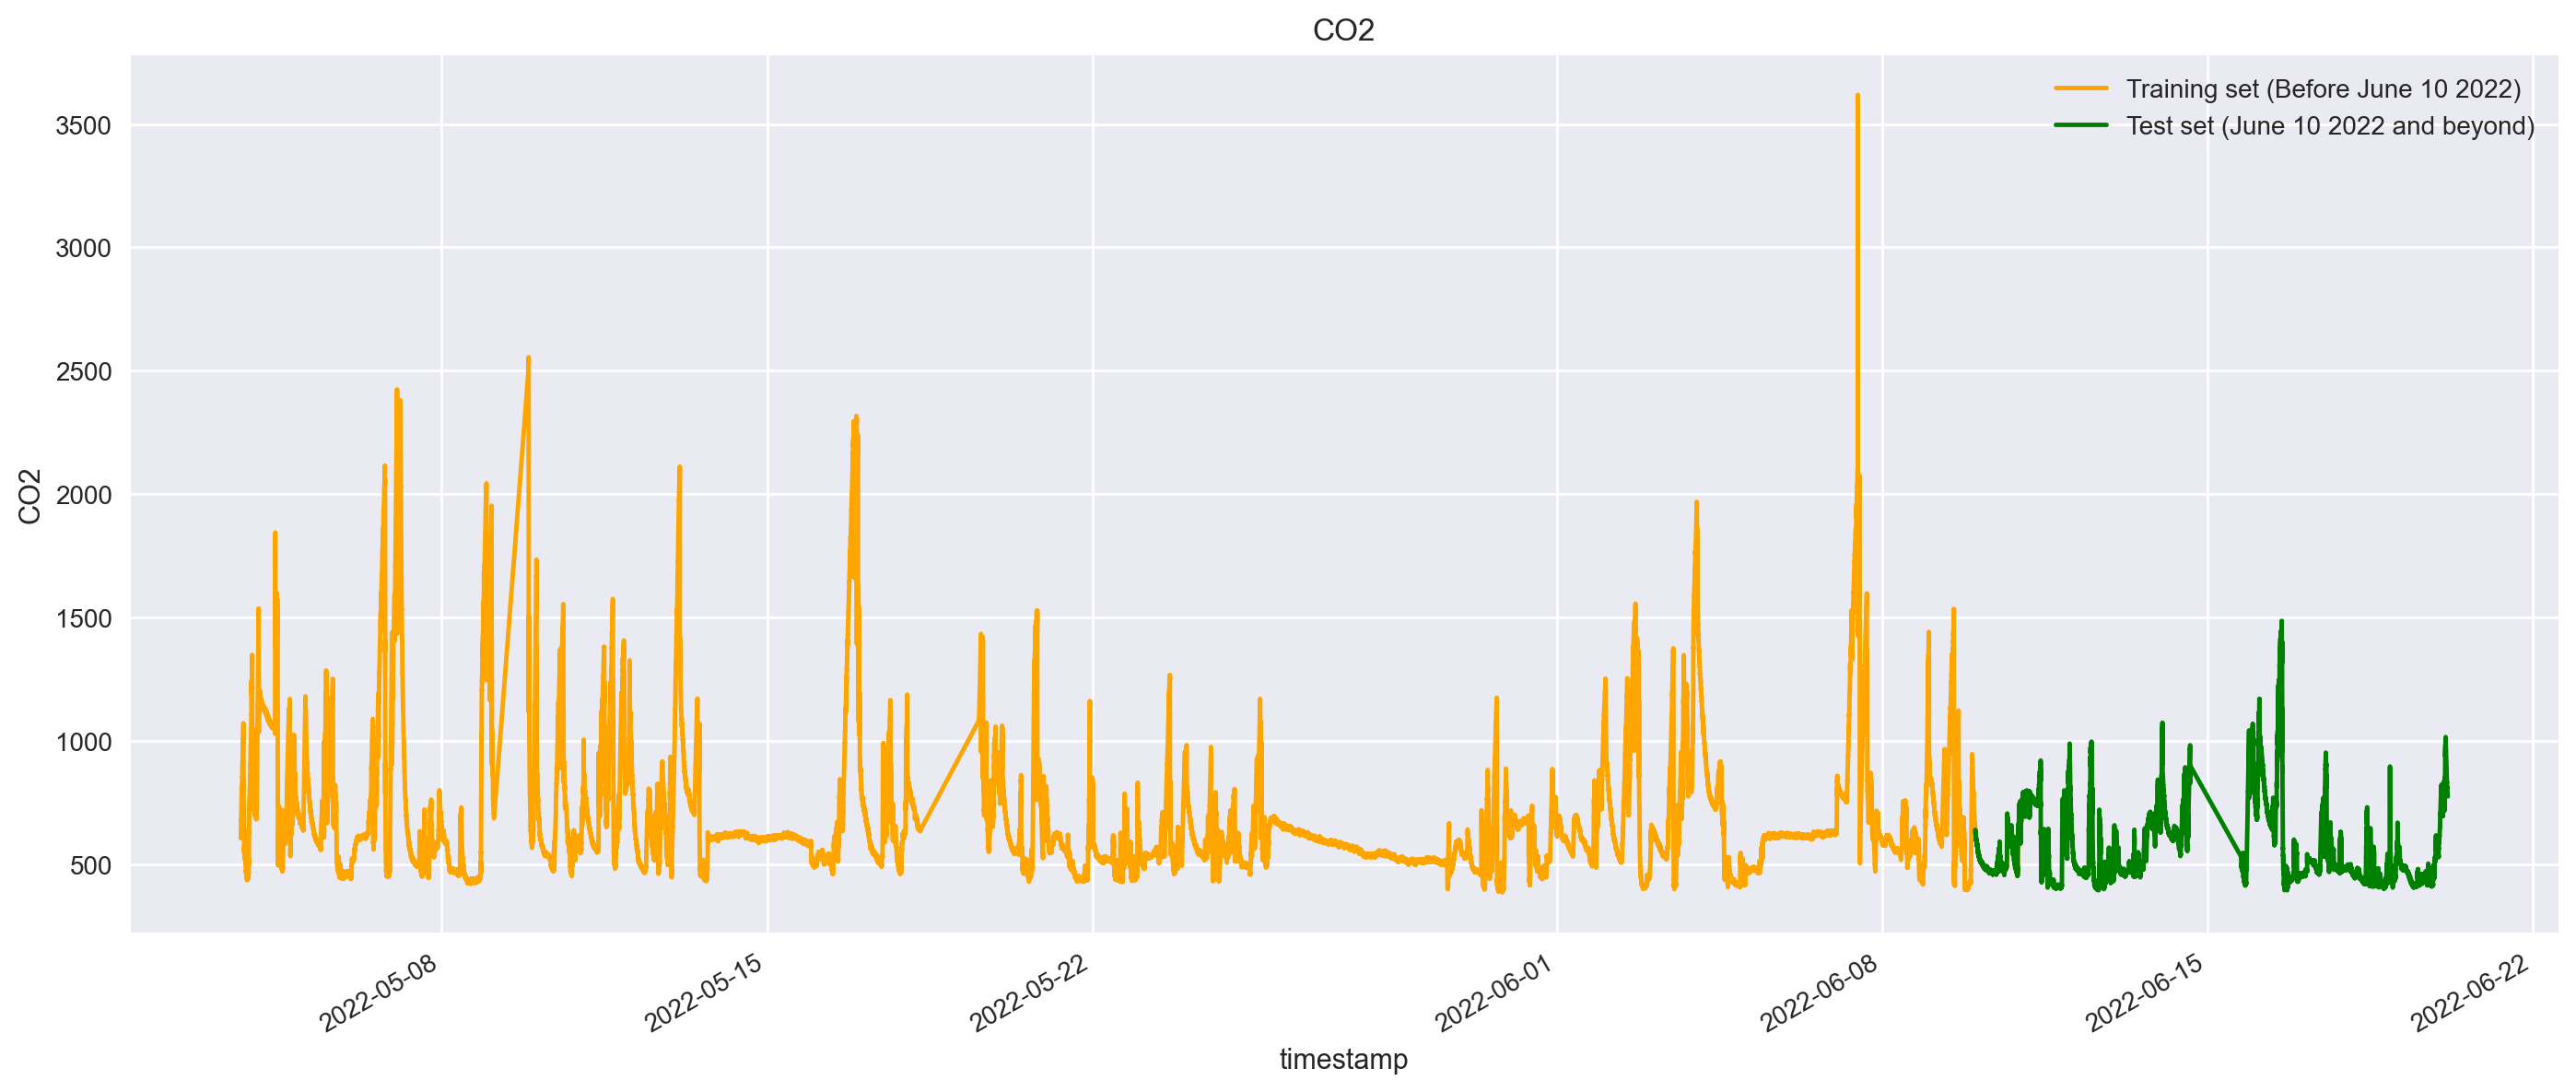

In [8]:
#Visualize our data - 2

plt.figure(dpi=200,figsize=(17,7))
data["co2"][:'2022-06-10'].plot(legend=True,color='orange')
data["co2"]['2022-06-10':].plot(legend=True,color='green')
plt.legend(['Training set (Before June 10 2022)','Test set (June 10 2022 and beyond)'])
plt.title('CO2')
plt.ylabel("CO2")
plt.show()

In [9]:
def make_dataset_many_to_many(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

In [10]:
train = data[:"2022-06-10"].values

#scale values between 0 and 1
scaler = minmax(feature_range=(0,1))

train = scaler.fit_transform(train)

trn_x,trn_y = make_dataset_many_to_many(train,2)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [17]:
trn_x = trn_x.reshape(-1,2,2)

print(trn_x.shape,trn_y.shape)

(298179, 2, 2) (298179, 2)


### Model Architecture

* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [18]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(50, return_sequences=True))
model.add(keras.layers.LSTM(50, return_sequences=True))
model.add(keras.layers.LSTM(50))

model.add(keras.layers.Dense(500))

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(2))

early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=15)
model.compile(optimizer='adam', loss='mse')

In [27]:
model.fit(trn_x, trn_y, epochs=1)

Epoch 1/1


ERROR:plaidml:Caused GPU Timeout Error (00000002:kIOAccelCommandBufferCallbackErrorTimeout)


    32/298179 [..............................] - ETA: 98:10:15 - loss: nan

ERROR:plaidml:Caused GPU Timeout Error (00000002:kIOAccelCommandBufferCallbackErrorTimeout)


    64/298179 [..............................] - ETA: 98:26:04 - loss: nan

ERROR:plaidml:Caused GPU Timeout Error (00000002:kIOAccelCommandBufferCallbackErrorTimeout)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignor

    96/298179 [..............................] - ETA: 98:46:59 - loss: nan

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubm

KeyboardInterrupt: 

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)


ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubmissionsIgnored)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (00000004:kIOAccelCommandBufferCallbackErrorSubm

## Validation

* Test our model on whole data including test set(2014 and beyond)

In [20]:
total = scaler.transform(data.values)
total_x,total_y = make_dataset_many_to_many(total,2)

In [21]:
predicted = model.predict(total_x)

In [22]:
predicted = scaler.inverse_transform(predicted)

In [23]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(data.iloc[2:])
infered['co2_predicted'] = predicted[:,0]

In [25]:
infered.tail()

,co2,livingroom_window_open,co2_predicted
timestamp,,,
2022-06-20 03:59:48.749000+00:00,776.09,True,NaN
2022-06-20 03:59:59.270000+00:00,775.12,True,NaN
2022-06-20 04:00:09.802000+00:00,775.55,True,NaN
2022-06-20 04:00:20.345000+00:00,775.17,True,NaN
2022-06-20 04:00:30.866000+00:00,774.25,True,NaN


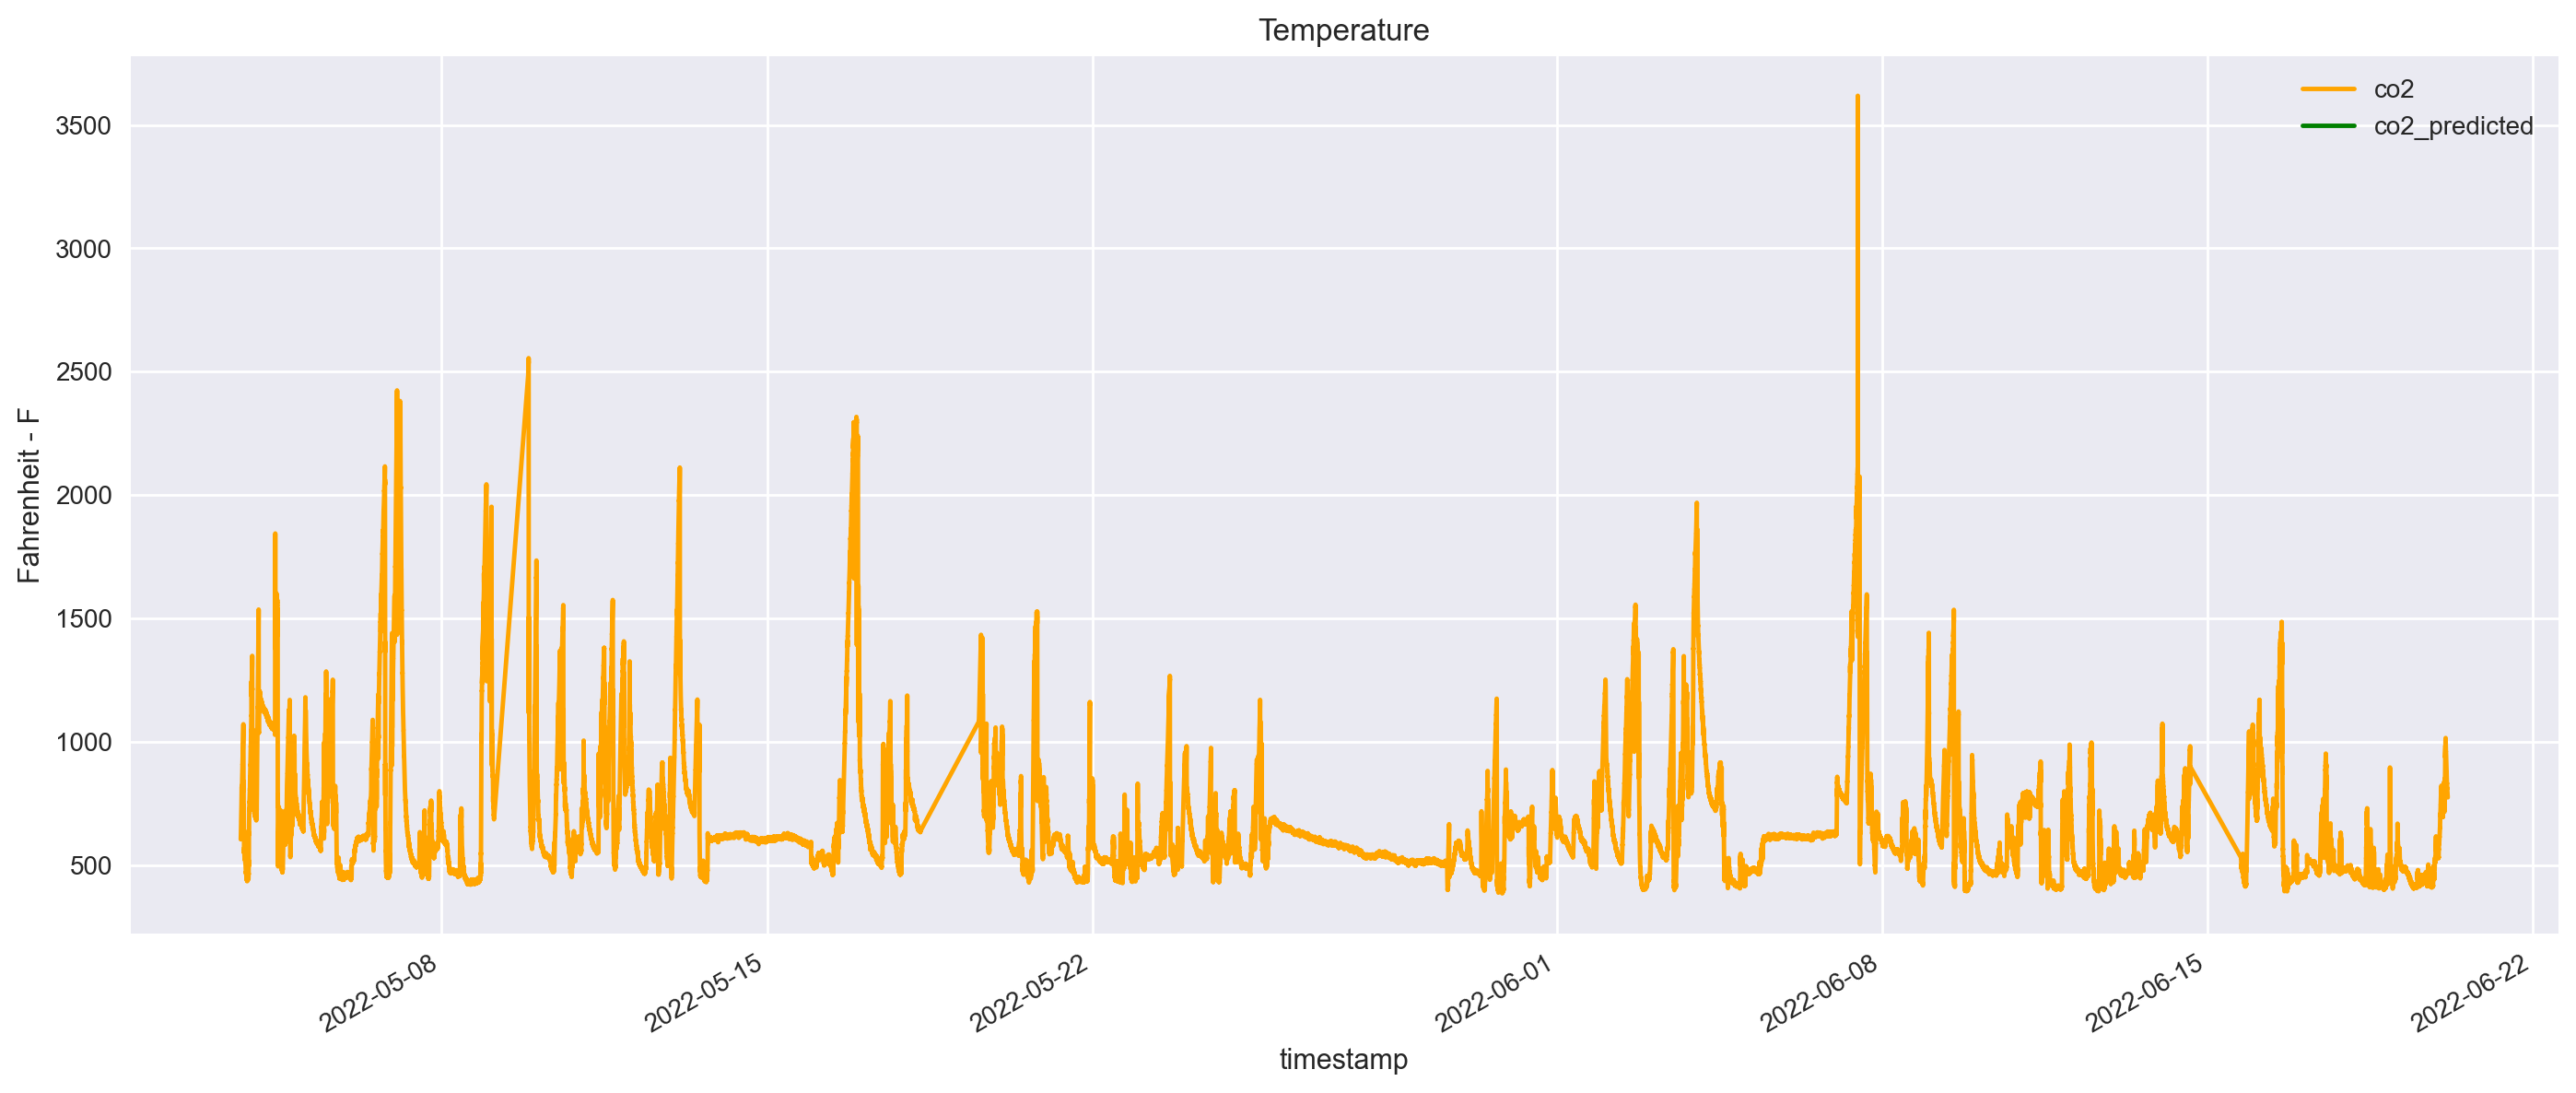

In [26]:
plt.figure(dpi=200,figsize=(17,7))
infered["co2"].plot(legend=True,color='orange')
infered["co2_predicted"].plot(legend=True,color='green')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

## Testset visualization

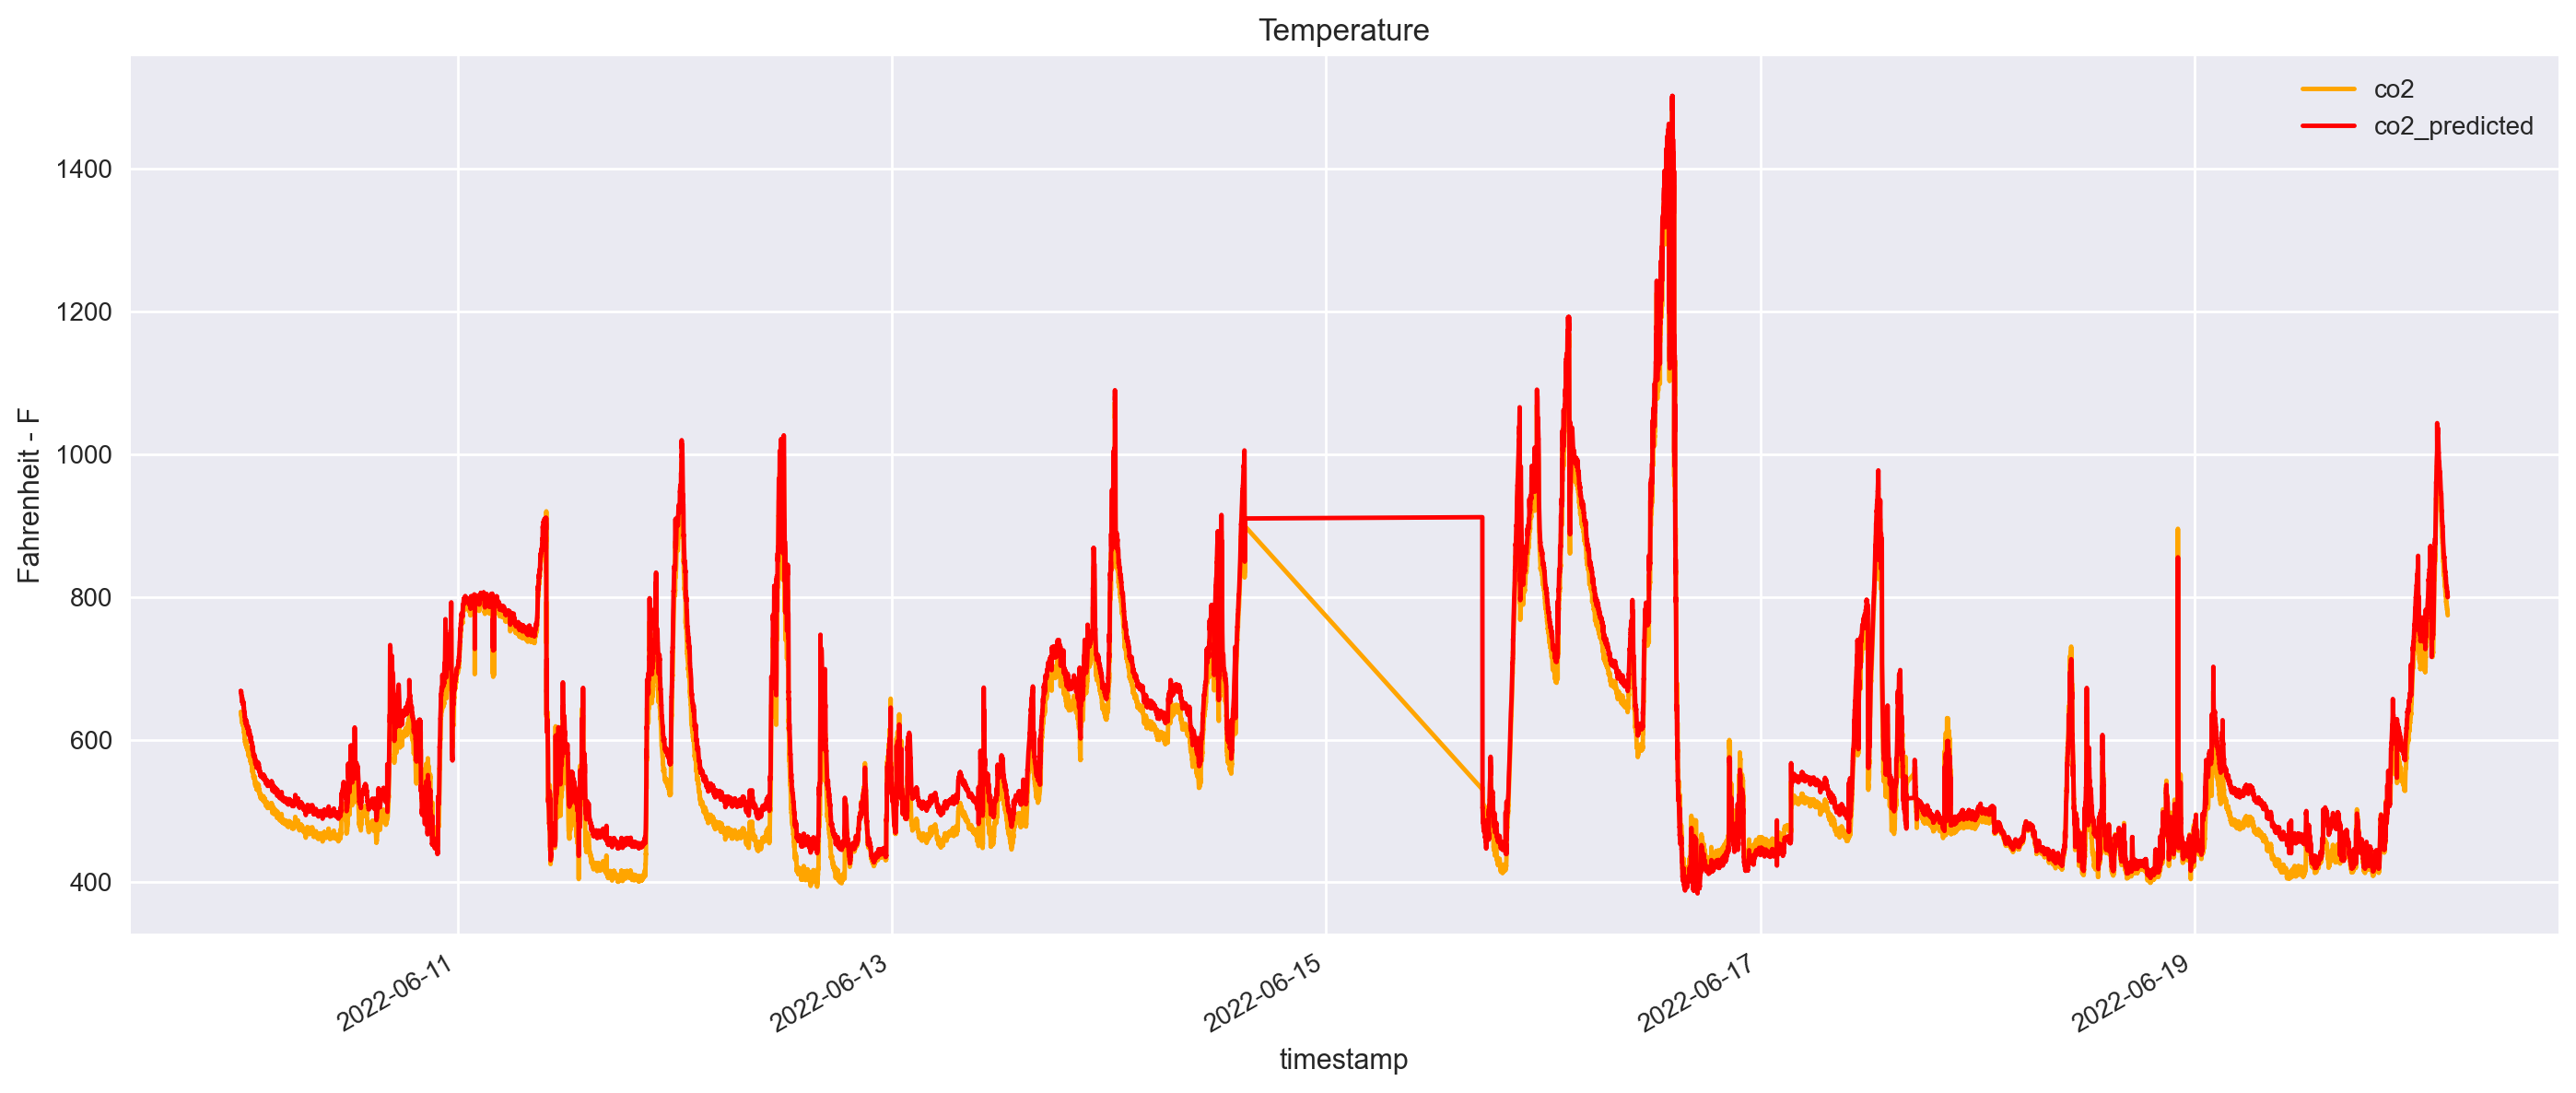

In [110]:
plt.figure(dpi=200,figsize=(17,7))
infered["2022-06-10":]["co2"].plot(legend=True,color='orange')
infered["2022-06-10":]["co2_predicted"].plot(legend=True,color='red')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

In [112]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(infered[["co2"]],infered[["co2_predicted"]])
print("RMSE:", np.sqrt(mse))

RMSE: 26.58020717938191


In [27]:
#save model

model.save("model")